## Monte Carlo AI Agent 

#### Field Environment
Field Environment designed by Adam has been replicated here to be used by the Monte Carlo Agent

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, calendar, field, size=5, sow_limit=200, season=120):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        # self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = field
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(self.get_reward(), 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward

#### Monte Carlo Agent
Agent using the MCTS approach to figure out the best course of action

Branching Factor = numChoices_C_sowLimit
Branching Factor => 4C3 = 4 right now

In [5]:
import gym
import numpy as np
from tqdm.notebook import trange, tqdm
from itertools import combinations
from pptree import *
# global parameters for trials
# field_env = Field()


class Tree:
    def __init__(self, action, calendar, field, parent=None):
        self.children = {} # Dictionary object [action_seq: "tree node"]
#         self.children = [] # List object [action_seq...]
        self.parent = parent
        self.curr_action = action
        self.calendar = calendar # can also be used to identify level in tree
        self.field_env = Field(calendar, field)
        self.node_score = -1
        self.branch_yield = int(0)
        self.tree_level_yield = 0
        self.expanded = False
        self.curr_node_explored_count = 0
#         self.family = []
#         if head:
#             head.children.append(self)
        
        
    def populate_children(self):

        action_seq = combinations(possible_actions, sow_limit)
        
        for action in list(action_seq):
            self.children[action] = Tree(list(action), self.calendar+1, self.field_env.field, self)
#             self.children.append(Tree(list(action), self.calendar+1, self.field_env.field, self, self))
        

  0%|          | 0/10.0 [00:00<?, ?it/s]

 0 [] 225 -1
|
|---- 1 [0, 1, 2] 33 0.09166666666666666
|
|---- 1 [0, 1, 3] 32 0.08888888888888889
|
|---- 1 [0, 2, 3] 143 0.3972222222222222
|
|----|---- 2 [0, 1, 2] 33 0.14666666666666667
|
|----|----|---- 3 [0, 1, 2] 27 0.25
|
|----|----|---- 3 [0, 1, 3] 28 0.25925925925925924
|
|----|----|---- 3 [0, 2, 3] 28 0.25925925925925924
|
|----|----|---- 3 [1, 2, 3] 25 0.23148148148148148
|
|----|---- 2 [0, 1, 3] 27 0.12
|
|----|---- 2 [0, 2, 3] 27 0.12
|
|----|---- 2 [1, 2, 3] 30 0.13333333333333333
|
|---- 1 [1, 2, 3] 35 0.09722222222222222
|

Best Path Identified [[0, 2, 3], [0, 1, 2], [0, 2, 3]]


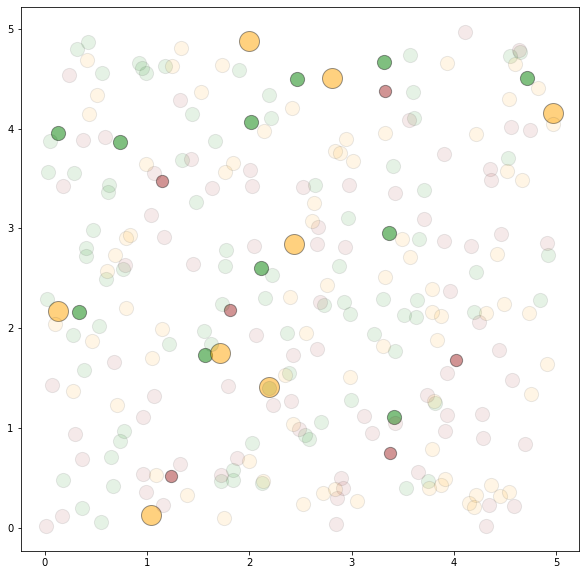

Total yield in Calories is 37.1.
---

SIMULATION COMPLETE


In [7]:
def mc_update(tree_node, update_val):
    
    if tree_node.calendar == 0:
        return
    
#     print("--"*tree_node.calendar,"update level", tree_node.calendar)
    
    tree_node.parent.branch_yield += int(update_val)
    
    curr_tree_level_yield = tree_node.tree_level_yield + update_val
    
#     print("curr_tly", curr_tree_level_yield)
    
    for key in tree_node.parent.children:
        
        sibling = tree_node.parent.children[key]
        
#         print("sib_tly", sibling.tree_level_yield)
        
        if curr_tree_level_yield != sibling.tree_level_yield:
            
            sibling.tree_level_yield += update_val
            
            if sibling.tree_level_yield != curr_tree_level_yield:
                print("error in logic")
            
#         print("sibling node score before", sibling.node_score)
                
        sibling.node_score = sibling.branch_yield/sibling.tree_level_yield
            
#         print("sibling node score after", sibling.node_score)
            
    mc_update(tree_node.parent, update_val)
        
    
def mc_selection(tree_node):
    global total_nodes_explored_count
    
    best_child = None
    best_score = -1
    
    for key in tree_node.children:

            child = tree_node.children[key]
            
            curr_score = child.node_score + np.sqrt( (2 * np.log(total_nodes_explored_count)) / (child.curr_node_explored_count) )
            
            if curr_score > best_score:
                
                best_score = curr_score
                best_child = child
    
    return best_child

            
def mc_get_score(tree_node, denominator):
    
    for key in tree_node.children:

        child = tree_node.children[key]
            
        child.node_score = child.branch_yield/denominator
            
        child.tree_level_yield = denominator
            
    
def mc_simulation(tree_node):
    done = False
    
    reward = 0
    
    original_field = Field(tree_node.calendar, tree_node.field_env.field)
    
    observation, reward, done, _ = tree_node.field_env.step(tree_node.curr_action)
    
    while not done:
        
        action = np.random.choice(4, sow_limit, replace=False)
        
#         print("rand action", action)
    
        observation, reward, done, _ = tree_node.field_env.step(action)
  
#     if done:
#         tree_node.field_env.render()
    
    tree_node.field_env = original_field
        
    tree_node.branch_yield = int(reward)
    
    
def MCTS_r(tree_node):
    global total_nodes_explored_count, pbar
#    needs moving into expanded condition

    just_expanded = False
    
    while True:
#         print("------")
#         print("Tree Level:", tree_node.calendar)
#         print("Action Seq:", tree_node.curr_action)
        pbar.update(total_nodes_explored_count)
        
#         print("tnec", total_nodes_explored_count)
        
        if total_nodes_explored_count >= total_nodes_to_explore:
#             print("End Condition Return")
            return
        
        if not tree_node.expanded:
            
            tree_node.populate_children()
            
#             print("Expansion")

            denominator = 0
            for key in tree_node.children:

                child = tree_node.children[key]

                if child.node_score == -1:

                    mc_simulation(child)

                    child.curr_node_explored_count += 1
                    total_nodes_explored_count += 1
#                     print("tnec2", total_nodes_explored_count)

                    denominator += child.branch_yield

            mc_get_score(tree_node, denominator)
        
#             print("update score", denominator)
            
            mc_update(tree_node, denominator)

            tree_node.expanded = True
            
            just_expanded = True

        else:
#             print("Selection")

            selected_node = mc_selection(tree_node)
#             print("Selected Node:", selected_node.curr_action, selected_node.node_score)

            MCTS_r(selected_node)

        if tree_node.calendar != 0:
#             print("Tree Level",tree_node.calendar,"return")
            return
        
        
def print_tree_self(tree_node):
    
    print("|----"*tree_node.calendar, tree_node.calendar, tree_node.curr_action, tree_node.branch_yield , tree_node.node_score)
    print("|")
    
    for key in tree_node.children:
        print_tree_self(tree_node.children[key])
        
        
def determine_best_path(tree_node):
    global best_action_seq
    
    max_score = 0
    max_score_action = []
    
    for key in tree_node.children:
        child = tree_node.children[key]
        
        if child.node_score >= max_score:
            max_score = child.node_score
            max_score_action = child.curr_action
            
    if max_score:
        best_action_seq.append(max_score_action)
        determine_best_path(tree_node.children[tuple(max_score_action)])
        
        
def best_simulation():
    global best_action_seq
    
    reward = 0
    
    sim_field = Field(0, None)
    sim_field.reset()
    
    observation, reward, done = 0, 0, 0
    
    for action in best_action_seq:
    
        observation, reward, done, _ = sim_field.step(action)
    
    for i in range(sim_field.season - len(best_action_seq)):
        
        action = np.random.choice(4, sow_limit, replace=False)
    
        observation, reward, done, _ = sim_field.step(action)
  
    if done:
        sim_field.render()
    
    
def run_MCTS():
    root = Tree([], 0, None, None)
    root.field_env.reset()
    
    MCTS_r(root)
    pbar.close()
    print_tree_self(root)
    determine_best_path(root)
    print()
    print("Best Path Identified", best_action_seq)
    best_simulation()
    print("SIMULATION COMPLETE")
    

# ------------
best_yield = 0
yield_history = []
sow_limit = 3
num_choices = 4
possible_actions = [0, 1, 2, 3]

# num_expansion = 100

total_nodes_to_explore = 10
total_nodes_explored_count = 0

best_action_seq = []

step= 1
pbar = tqdm(total=total_nodes_to_explore/step)

np.random.seed(2)

run_MCTS()
# ------------